In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


<AxesSubplot: xlabel='X'>

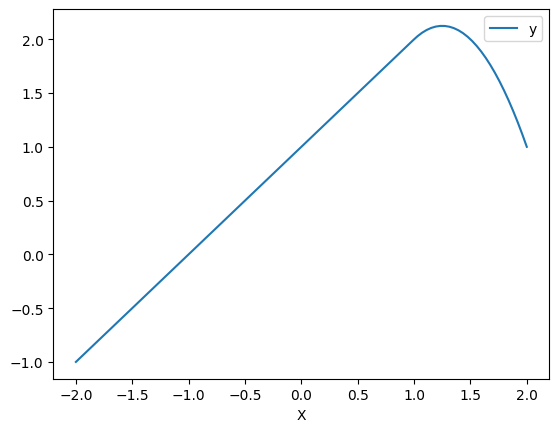

In [10]:
#conceptual 1
X = np.linspace(-2, 2, 100)
df = pd.DataFrame(X, columns = ['X'])
df['y'] = 1 + df['X'] #beta 0
df['y'] += (-2*(df['X']-1)**2)*(df['X']>=1).mul(1)
df.plot(x='X', y='y')